# Image Recognition Covid Detection - Multi Classification[1]

## Import Package

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import itertools
import os
import torchvision
from torch import nn, optim
from jcopdl.callback import Callback, set_config
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
from jcopdl.layers import linear_block, conv_block
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Dataset dan Dataloader

In [ ]:
bs = 128
crop_size = 224 #jika image ukurannya berbeda-beda (crop&resize)

train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomRotation(15), # 15 derajat
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)), # cropnya jangan terlalu kecil, 80%-100% dari gambar baru di resize
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("C:/Users/Ridho Alhafizhi/Downloads/tutorial koding/14_tutorial koding Data Science,ML,DM/Machine Learning/Datasets/Datasets Covid-19/Datasets-Covid-MultiClass/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("C:/Users/Ridho Alhafizhi/Downloads/tutorial koding/14_tutorial koding Data Science,ML,DM/Machine Learning/Datasets/Datasets Covid-19/Datasets-Covid-MultiClass/test", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [4]:
#cek
loader = iter(trainloader)
images, labels = next(loader)
images.shape

torch.Size([128, 1, 224, 224])

In [5]:
label2cat = train_set.classes
label2cat

['Covid-19', 'Normal', 'Pneumonia']

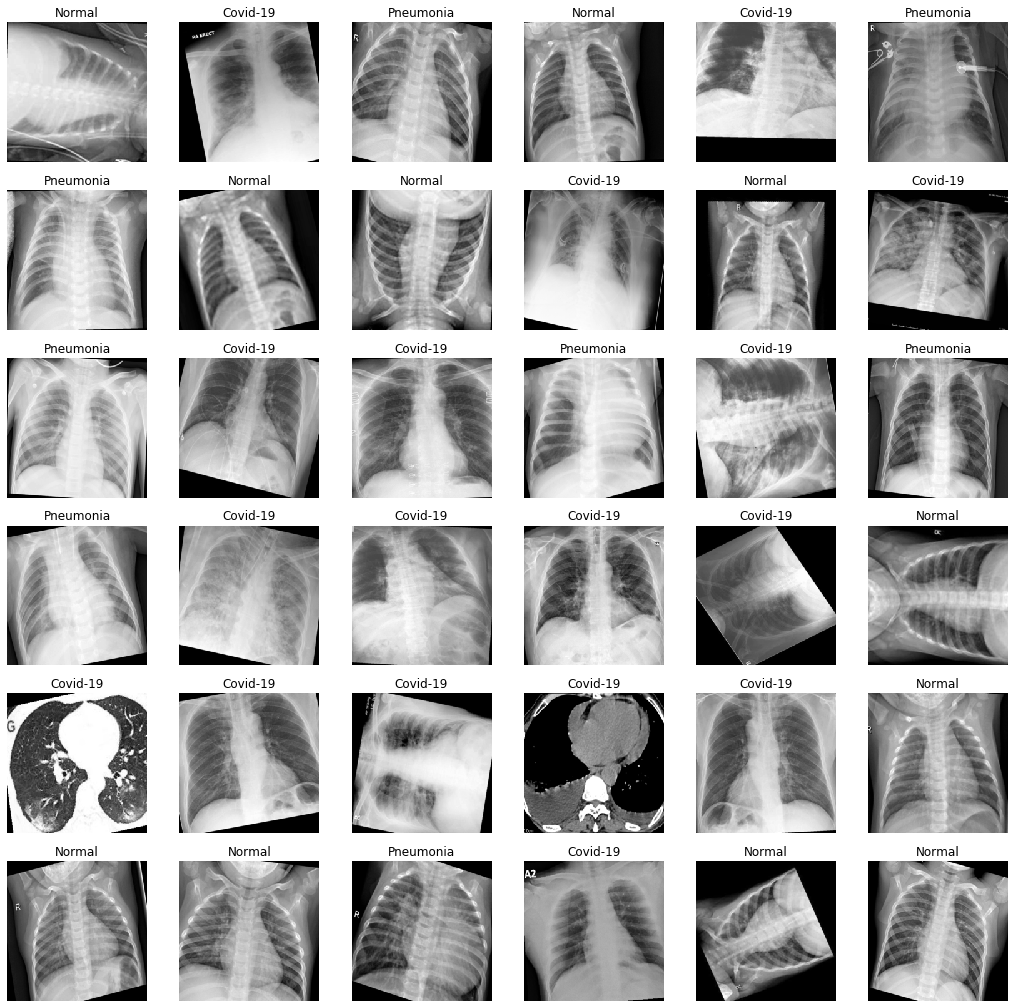

In [5]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))
for img, label, ax in zip(images, labels, axes.flatten()):
    ax.imshow(img.view(224, 224).cpu(), cmap='gray')
#     ax.imshow(img.permute(2, 1, 0).cpu())
    label = label2cat[label.item()]
    ax.set_title(f"{label}")
    ax.axis('off');

## Arsitektur dan Config

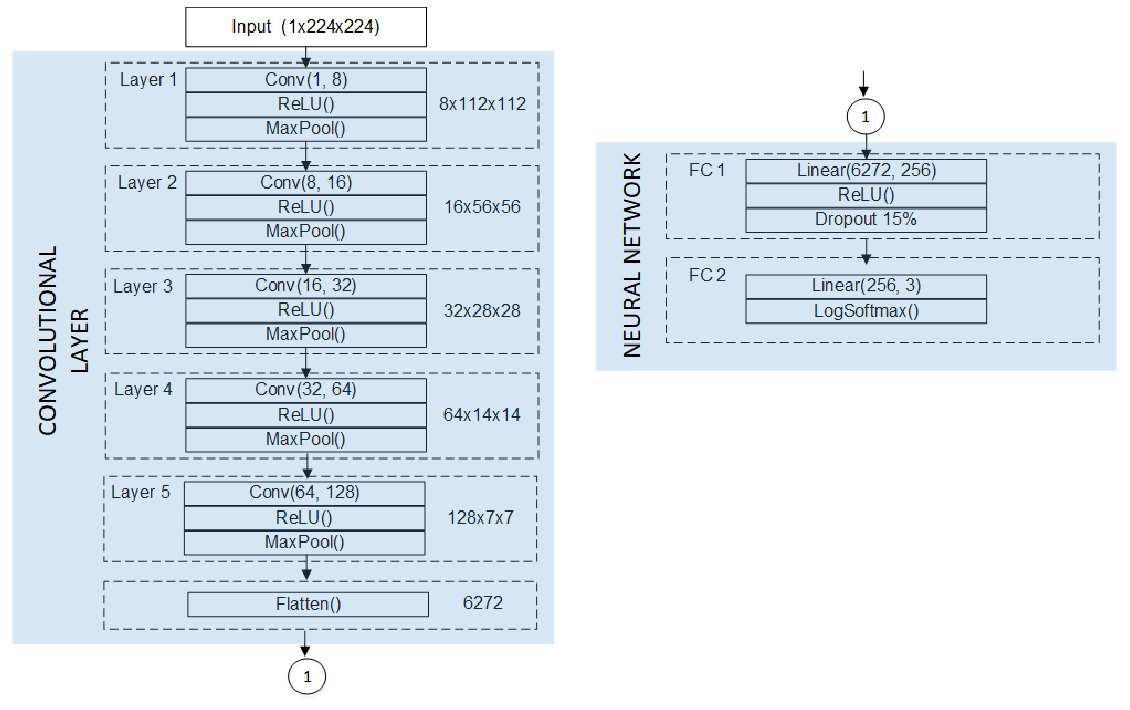

In [16]:
plt.figure(figsize=(20,25))
arsitektur = plt.imread('model-CNN/model-covid/model-covid-multiclass/model-tunning-1/plot/arsitektur_1.png')
plt.imshow(arsitektur)
plt.axis('off');

In [6]:
class CNN(nn.Module):
    def __init__(self, in_channel, conv1, conv2, conv3, conv4, kernel, pad, out_channel, in_size, n1, dropout, out_size):
        super().__init__()
        
        self.convolutional = nn.Sequential(
            
            conv_block(in_channel, conv1, kernel=kernel, pad=pad),
            conv_block(conv1, conv2, kernel=kernel, pad=pad),
            conv_block(conv2, conv3, kernel=kernel, pad=pad),
            conv_block(conv3, conv4, kernel=kernel, pad=pad),
            conv_block(conv4, out_channel, kernel=kernel, pad=pad),
            nn.Flatten()
            
        )
        
        self.fc = nn.Sequential(
            
            linear_block(in_size, n1, dropout=dropout),
            linear_block(n1, out_size, activation='lsoftmax')
        )
        
        
    def forward(self, x):
        x = self.convolutional(x)
        x = self.fc(x)
        return x
    
        

In [7]:
config = set_config ({
    
    "batch_size" : bs,
    "crop_size" : crop_size,
    "in_channel" : 1,
    "conv1" : 8,
    "conv2" : 16,
    "conv3" : 32,
    "conv4" : 64,
    "out_channel" : 128,
    "kernel" : 3,
    "pad" : 1,
    "in_size" : 128*7*7,
    "n1" : 256,
    "dropout" : 0.15,
    "out_size" : 3,
    "batch_norm" : "False",
    "author" : "Ridho Alhafizhi"
    
})

# torch.save(config, "model-CNN/model-covid/model-covid-multiclass/config.pth")

## Training Preparation >> MCOC

In [8]:
model = CNN(config.in_channel, config.conv1, config.conv2, config.conv3, config.conv4, config.kernel, config.pad, config.out_channel, config.in_size, config.n1, config.dropout, config.out_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model-CNN/model-covid/model-covid-multiclass/",early_stop_patience=10, plot_every=5)

In [14]:
model;

## Training

Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 1.0419 | Test_cost  = 0.8409 | Train_score = 0.4243 | Test_score = 0.6090 |


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.7685 | Test_cost  = 0.7284 | Train_score = 0.6443 | Test_score = 0.6410 |


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6542 | Test_cost  = 0.5707 | Train_score = 0.6931 | Test_score = 0.7578 |


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.4996 | Test_cost  = 0.3744 | Train_score = 0.7826 | Test_score = 0.8512 |


Test: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [00:53<00:00,  4.90s/it]



Epoch     5
Train_cost  = 0.4289 | Test_cost  = 0.3895 | Train_score = 0.8095 | Test_score = 0.8326 |


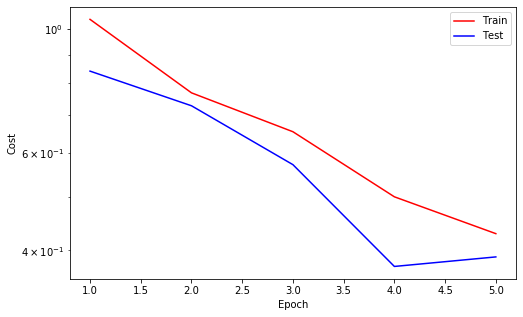

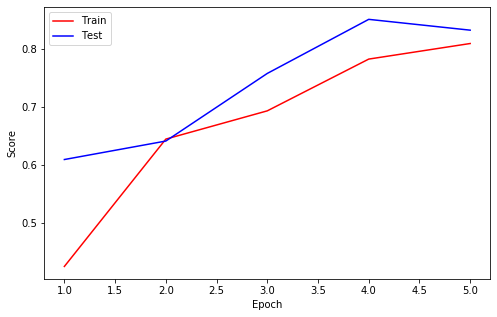

Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

==> EarlyStop patience =  1 | Best test_score: 0.8512


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.4103 | Test_cost  = 0.3447 | Train_score = 0.8288 | Test_score = 0.8660 |


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.3403 | Test_cost  = 0.3207 | Train_score = 0.8565 | Test_score = 0.8746 |


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.3331 | Test_cost  = 0.2595 | Train_score = 0.8602 | Test_score = 0.8941 |


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.2998 | Test_cost  = 0.2530 | Train_score = 0.8797 | Test_score = 0.8949 |


Test: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [00:54<00:00,  4.91s/it]



Epoch    10
Train_cost  = 0.2773 | Test_cost  = 0.2710 | Train_score = 0.8850 | Test_score = 0.8879 |


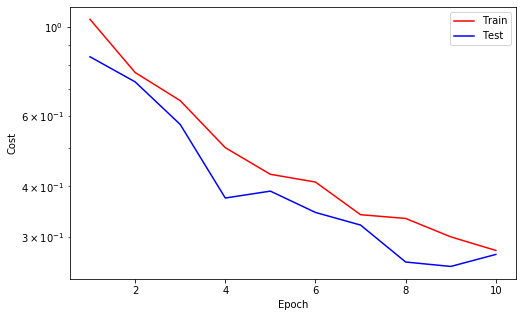

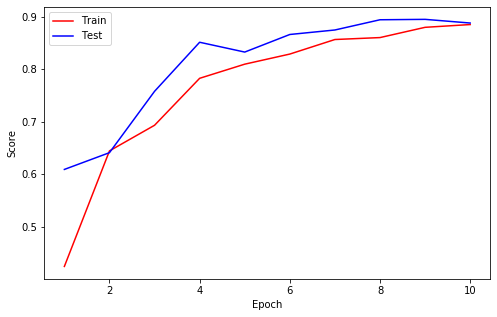

Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

==> EarlyStop patience =  1 | Best test_score: 0.8949


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.2743 | Test_cost  = 0.3098 | Train_score = 0.8860 | Test_score = 0.8629 |
==> EarlyStop patience =  2 | Best test_score: 0.8949


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.2552 | Test_cost  = 0.2383 | Train_score = 0.8934 | Test_score = 0.8964 |


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.2227 | Test_cost  = 0.2519 | Train_score = 0.9100 | Test_score = 0.9026 |


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.2309 | Test_cost  = 0.2263 | Train_score = 0.9047 | Test_score = 0.9034 |


Test: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [00:53<00:00,  4.83s/it]



Epoch    15
Train_cost  = 0.2069 | Test_cost  = 0.2388 | Train_score = 0.9177 | Test_score = 0.9042 |


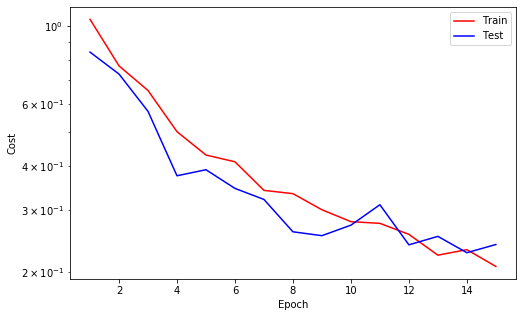

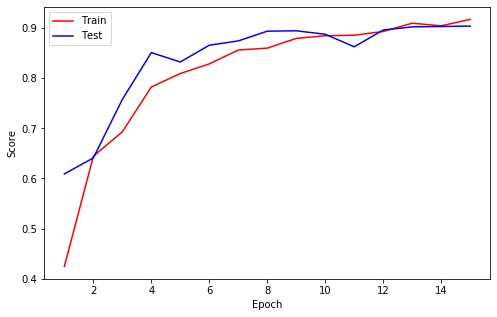

Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.2246 | Test_cost  = 0.3249 | Train_score = 0.9103 | Test_score = 0.8660 |
==> EarlyStop patience =  1 | Best test_score: 0.9042


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.2023 | Test_cost  = 0.2957 | Train_score = 0.9182 | Test_score = 0.8816 |
==> EarlyStop patience =  2 | Best test_score: 0.9042


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.2293 | Test_cost  = 0.2127 | Train_score = 0.9042 | Test_score = 0.9112 |


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.1905 | Test_cost  = 0.1994 | Train_score = 0.9193 | Test_score = 0.9159 |


Test: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [01:11<00:00,  6.48s/it]



Epoch    20
Train_cost  = 0.1643 | Test_cost  = 0.1957 | Train_score = 0.9325 | Test_score = 0.9221 |


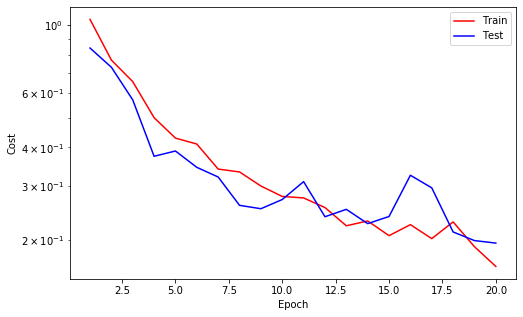

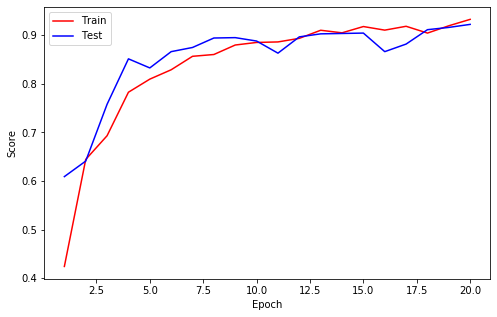

Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.1582 | Test_cost  = 0.2942 | Train_score = 0.9385 | Test_score = 0.8941 |
==> EarlyStop patience =  1 | Best test_score: 0.9221


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.1838 | Test_cost  = 0.1898 | Train_score = 0.9285 | Test_score = 0.9174 |
==> EarlyStop patience =  2 | Best test_score: 0.9221


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.1590 | Test_cost  = 0.2000 | Train_score = 0.9377 | Test_score = 0.9151 |
==> EarlyStop patience =  3 | Best test_score: 0.9221


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.1495 | Test_cost  = 0.2262 | Train_score = 0.9375 | Test_score = 0.9104 |
==> EarlyStop patience =  4 | Best test_score: 0.9221


Test: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [01:01<00:00,  5.64s/it]



Epoch    25
Train_cost  = 0.1553 | Test_cost  = 0.2651 | Train_score = 0.9385 | Test_score = 0.9058 |


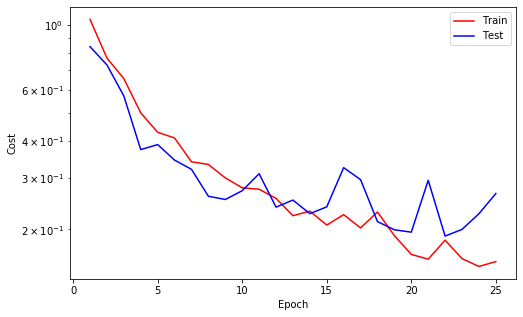

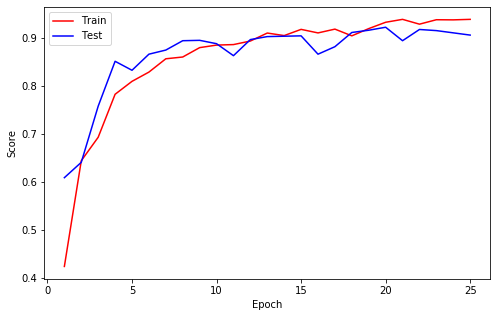

Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

==> EarlyStop patience =  5 | Best test_score: 0.9221


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.1809 | Test_cost  = 0.2336 | Train_score = 0.9303 | Test_score = 0.9003 |
==> EarlyStop patience =  6 | Best test_score: 0.9221


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.1354 | Test_cost  = 0.2114 | Train_score = 0.9488 | Test_score = 0.9174 |
==> EarlyStop patience =  7 | Best test_score: 0.9221


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.1283 | Test_cost  = 0.1999 | Train_score = 0.9488 | Test_score = 0.9174 |
==> EarlyStop patience =  8 | Best test_score: 0.9221


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.1384 | Test_cost  = 0.1889 | Train_score = 0.9438 | Test_score = 0.9190 |
==> EarlyStop patience =  9 | Best test_score: 0.9221


Test: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [01:03<00:00,  5.76s/it]



Epoch    30
Train_cost  = 0.1470 | Test_cost  = 0.2190 | Train_score = 0.9417 | Test_score = 0.9112 |


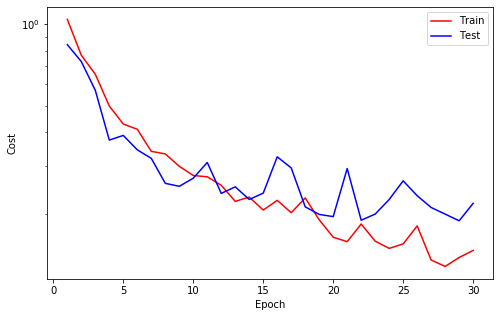

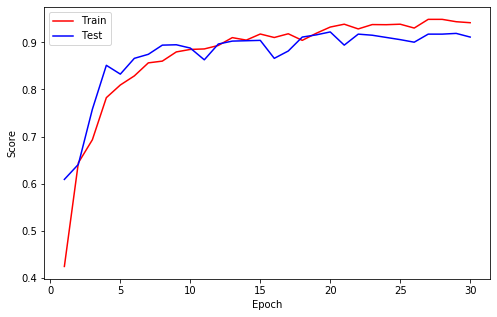

==> EarlyStop patience = 10 | Best test_score: 0.9221
==> Execute Early Stopping at epoch: 30 | Best test_score: 0.9221
==> Best model is saved at model-CNN/model-covid/model-covid-multiclass/


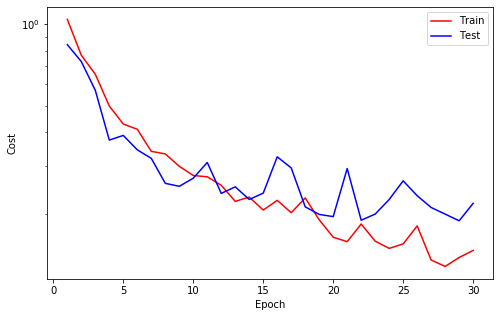

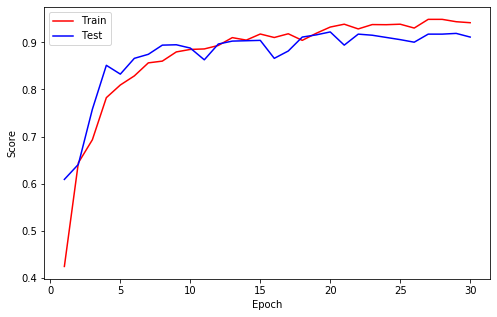

In [22]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
        
    cost = correct = 0
    
    for feature, target in tqdm(dataloader, desc=mode.title()):
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Evaluasi Model

### Akurasi dan Cost

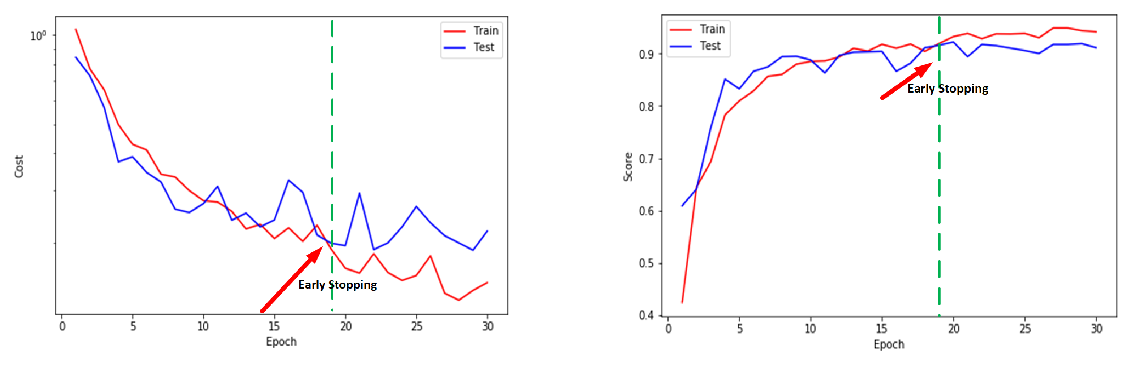

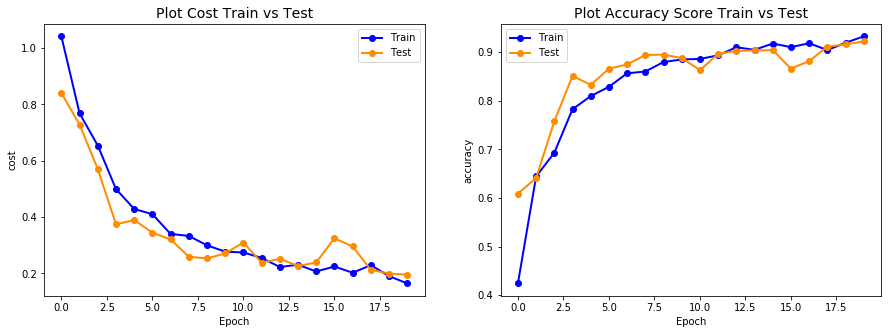

In [10]:
df = pd.DataFrame(torch.load("model-CNN/model-covid/model-covid-multiclass/model-tunning-1/report/logs.pth", map_location="cpu"))
df;

plt.figure(figsize=(20,10))
plt.subplot(121)
train_cm = plt.imread('model-CNN/model-covid/model-covid-multiclass/model-tunning-1/plot/AR1_early_stop_cost.png')
plt.imshow(train_cm)
plt.axis('off');

plt.subplot(122)
test_cm = plt.imread('model-CNN/model-covid/model-covid-multiclass/model-tunning-1/plot/AR1_early_stop_score.png')
plt.imshow(test_cm) 
plt.axis('off');


plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Plot Cost Train vs Test", fontsize=14)
plt.plot(df.train_cost, 'bo-',linewidth=2, label="Train")
plt.plot(df.test_cost, color='darkorange', marker='o', linewidth=2, label="Test")
plt.xlabel("Epoch"); plt.ylabel("cost"); plt.legend();

plt.subplot(122)
plt.title("Plot Accuracy Score Train vs Test", fontsize=14)
plt.plot(df.train_score, 'bo-',linewidth=2, label="Train")
plt.plot(df.test_score, color='darkorange',marker='o', linewidth=2, label="Test")
plt.xlabel("Epoch"); plt.ylabel("accuracy"); plt.legend();

### Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=28)

    plt.tight_layout()
    plt.ylabel('Actual Labels', fontsize=18)
    plt.xlabel('Predicted Labels',fontsize=18)
    
    
# Graphical analytics
def predictionsplot_train(model, device, trainloader):
        model.train(False)
        actuals = []
        predictions = []
        with torch.no_grad():
            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(labels.view_as(prediction))
                predictions.extend(prediction)
        return [i.item() for i in actuals], [i.item() for i in predictions]
    
actuals, predictions = predictionsplot_train(model, device, trainloader)
cm = confusion_matrix(actuals, predictions)
names = (train_set.classes)

# plt.figure(figsize=(10,10))
# plt.title('Confusion Matrix Training', fontsize=24)
# plot_confusion_matrix(cm, names)
# plt.savefig("model-CNN/model-covid/model-covid-multiclass/plot_cm_train.png")

confusion_matrix(actuals, predictions)

target_names = train_set.classes
report = (classification_report(actuals, predictions, target_names=target_names))
torch.save(report, "model-CNN/model-covid/model-covid-multiclass/report_train.pth")
print(report)

# # accuracy: (tp + tn) / (p + n)
# accuracy = accuracy_score(actuals, predictions)
# # precision tp / (tp + fp)
# precision = precision_score(actuals, predictions)
# # recall: tp / (tp + fn)
# recall = recall_score(actuals, predictions)
# # f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(actuals, predictions)

# train_report = set_config ({
    
#     "accuracy" : accuracy,
#     "recall_score" : recall,
#     "precision_score" : precision,
#     "f1_score" : f1
# })

# torch.save(train_report,"model-CNN/model-covid/model-covid-multiclass/train_report.pth")

    
# Graphical analytics
def predictionsplot_test(model, device, testloader):
        model.eval(False)
        actuals = []
        predictions = []
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(labels.view_as(prediction))
                predictions.extend(prediction)
        return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = predictionsplot_test(model, device, testloader)
cm = confusion_matrix(actuals, predictions)
names = (train_set.classes)

plt.figure(figsize=(10,10))
plt.title('Confusion Matrix Testing', fontsize=24)
plot_confusion_matrix(cm, names)
plt.savefig("model-CNN/model-covid/model-covid-multiclass/plot_cm_test.png")

# # accuracy: (tp + tn) / (p + n)
# accuracy = accuracy_score(actuals, predictions)
# # precision tp / (tp + fp)
# precision = precision_score(actuals, predictions)
# # recall: tp / (tp + fn)
# recall = recall_score(actuals, predictions)
# # f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(actuals, predictions)

# test_report = set_config ({
    
#     "accuracy" : accuracy,
#     "recall_score" : recall,
#     "precision_score" : precision,
#     "f1_score" : f1
# })

# torch.save(test_report,"model-CNN/model-covid/model-covid-multiclass/test_report.pth")

target_names = train_set.classes
report = (classification_report(actuals, predictions, target_names=target_names))
torch.save(report, "model-CNN/model-covid/model-covid-multiclass/report_test.pth" )
print(report)

 << Testing Report >> 

              precision    recall  f1-score   support

    Covid-19       0.94      0.91      0.93       427
      Normal       0.90      0.88      0.89       431
   Pneumonia       0.92      0.98      0.95       426

    accuracy                           0.92      1284
   macro avg       0.92      0.92      0.92      1284
weighted avg       0.92      0.92      0.92      1284



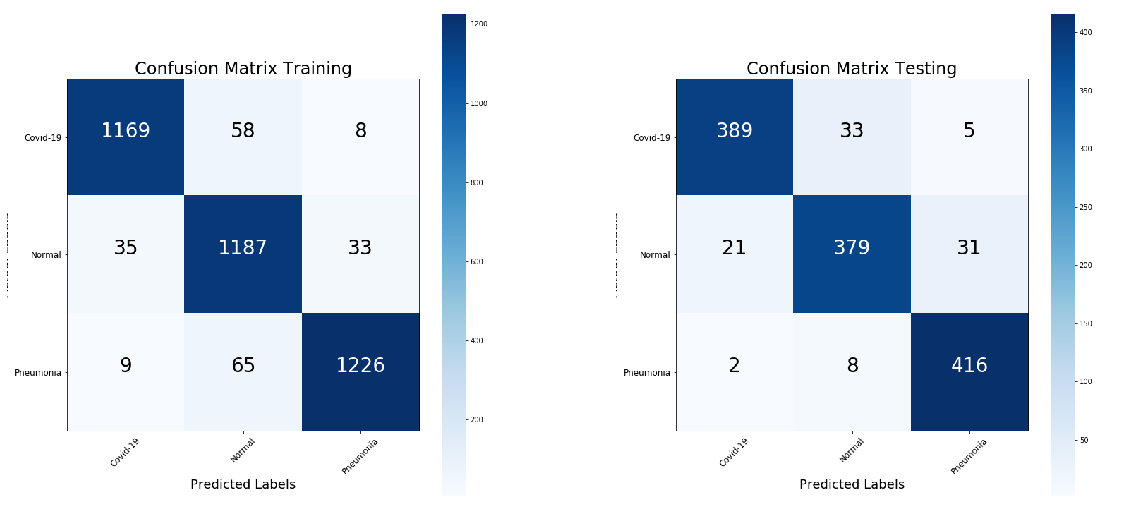

In [13]:
print(" << Testing Report >> \n")
print(torch.load("model-CNN/model-covid/model-covid-multiclass/model-tunning-1/report/report.pth"))

plt.figure(figsize=(20,25))
plt.subplot(121)
train_cm = plt.imread('model-CNN/model-covid/model-covid-multiclass/model-tunning-1/plot/plot_cm_train.png')
plt.imshow(train_cm)
plt.axis('off');

plt.subplot(122)
test_cm = plt.imread('model-CNN/model-covid/model-covid-multiclass/model-tunning-1/plot/plot_cm_test.png')
plt.imshow(test_cm) 
plt.axis('off');

### ROC Plot

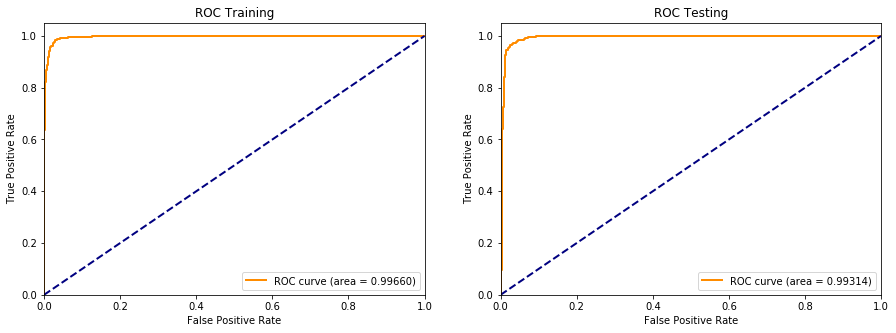

In [26]:
def test_class_probabilities(model, device, testloader, which_class):
    model.eval()
    actuals_test = []
    probabilities = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals_test.extend(labels.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals_test], [i.item() for i in probabilities]

which_class = 2 #[0,1,2]
actuals_test, class_probabilities = test_class_probabilities(model, device, testloader, which_class)

fpr_test, tpr_test, _ = roc_curve(actuals_test, class_probabilities)
roc_auc_test = auc(fpr_test, tpr_test)


def train_class_probabilities(model, device, trainloader, which_class):
    model.train(mode=False)
    actuals_train = []
    probabilities = []
    with torch.no_grad():
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals_train.extend(labels.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals_train], [i.item() for i in probabilities]

which_class = 2 #[0,1,2]
actuals_train, class_probabilities = train_class_probabilities(model, device, trainloader, which_class)

fpr_train, tpr_train, _ = roc_curve(actuals_train, class_probabilities)
roc_auc_train = auc(fpr_train, tpr_train)


#ploting ROC_curve
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(fpr_train, tpr_train, color='darkorange',lw=2, label='ROC curve (area = %0.5f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Training')
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(fpr_test, tpr_test, color='darkorange',lw=2, label='ROC curve (area = %0.5f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Testing')
plt.legend(loc="lower right")

plt.savefig("model-CNN/model-covid/model-covid-multiclass/plot_roc.png")
plt.show()

## Load Model

In [329]:
weights = torch.load("model-CNN/model-covid/model-covid-multiclass/weights_best.pth", map_location="cpu")
model.load_state_dict(weights)
model = model.to(device);

In [330]:
torch.load("model-CNN/model-covid/model-covid-multiclass/configs.pth")

Config(author=Ridho Alhafizhi, batch_norm=False, batch_size=128, conv1=8, conv2=16, conv3=32, conv4=64, crop_size=224, dropout=0.15, in_channel=1, in_size=6272, kernel=3, n1=256, out_channel=128, out_size=3, pad=1)

In [331]:
df = pd.DataFrame(torch.load("model-CNN/model-covid/model-covid-multiclass/logs.pth", map_location="cpu"))
df

plot_tick  best_score  train_cost  train_score  test_cost  test_score
0           1    0.922118    1.041932     0.424274   0.840852    0.609034
1           2    0.922118    0.768528     0.644327   0.728444    0.640966
2           3    0.922118    0.654164     0.693140   0.570749    0.757788
3           4    0.922118    0.499603     0.782586   0.374419    0.851246
4           5    0.922118    0.428903     0.809499   0.389505    0.832555
5           6    0.922118    0.410271     0.828760   0.344717    0.866044
6           7    0.922118    0.340309     0.856464   0.320676    0.874611
7           8    0.922118    0.333054     0.860158   0.259493    0.894081
8           9    0.922118    0.299777     0.879683   0.253006    0.894860
9          10    0.922118    0.277305     0.884960   0.271024    0.887850
10         11    0.922118    0.274258     0.886016   0.309754    0.862928
11         12    0.922118    0.255217     0.893404   0.238280    0.896417
12         13    0.922118    0.222715     0.910026   0.251851    0.902648
13         14    0.922118    0.230900     0.904749   0.226326    0.903427
14         15    0.922118    0.206860     0.917678   0.238757    0.904206
15         16    0.922118    0.224603     0.910290   0.324894    0.866044
16         17    0.922118    0.202315     0.918206   0.295693    0.881620
17         18    0.922118    0.229255     0.904222   0.212654    0.911215
18         19    0.922118    0.190472     0.919261   0.199378    0.915888
19         20    0.922118    0.164341     0.932454   0.195696    0.922118

In [1]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title("Plot Cost Train vs Test", fontsize=14)
plt.plot(df.train_cost, 'bo-',linewidth=2, label="Train")
plt.plot(df.test_cost, color='darkorange', marker='o', linewidth=2, label="Test")
plt.xlabel("Epoch"); plt.ylabel("cost"); plt.legend();

plt.subplot(122)
plt.title("Plot Accuracy Score Train vs Test", fontsize=14)
plt.plot(df.train_score, 'bo-',linewidth=2, label="Train")
plt.plot(df.test_score, color='darkorange',marker='o', linewidth=2, label="Test")
plt.xlabel("Epoch"); plt.ylabel("accuracy"); plt.legend();

plt.savefig("model-CNN/model-covid/model-covid-multiclass/plot_score_cost_earlystop.png")

NameError: name 'plt' is not defined

## Prediction

In [294]:
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

In [295]:
with torch.no_grad():
    model.eval()
    output = model(images)
    preds = output.argmax(1)
preds

tensor([1, 0, 2, 1, 1, 2, 0, 1, 2, 1, 2, 0, 0, 1, 1, 2, 2, 2, 1, 0, 2, 2, 1, 2,
        0, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 0, 1, 2, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 2, 0, 1, 1, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 2,
        1, 0, 1, 0, 1, 2, 0, 2, 2, 0, 2, 1, 0, 0, 0, 0, 1, 2, 1, 1, 2, 2, 1, 2,
        2, 2, 0, 1, 1, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 0, 1, 2, 0, 0, 1, 2, 1, 0,
        2, 2, 0, 1, 2, 2, 0, 0])

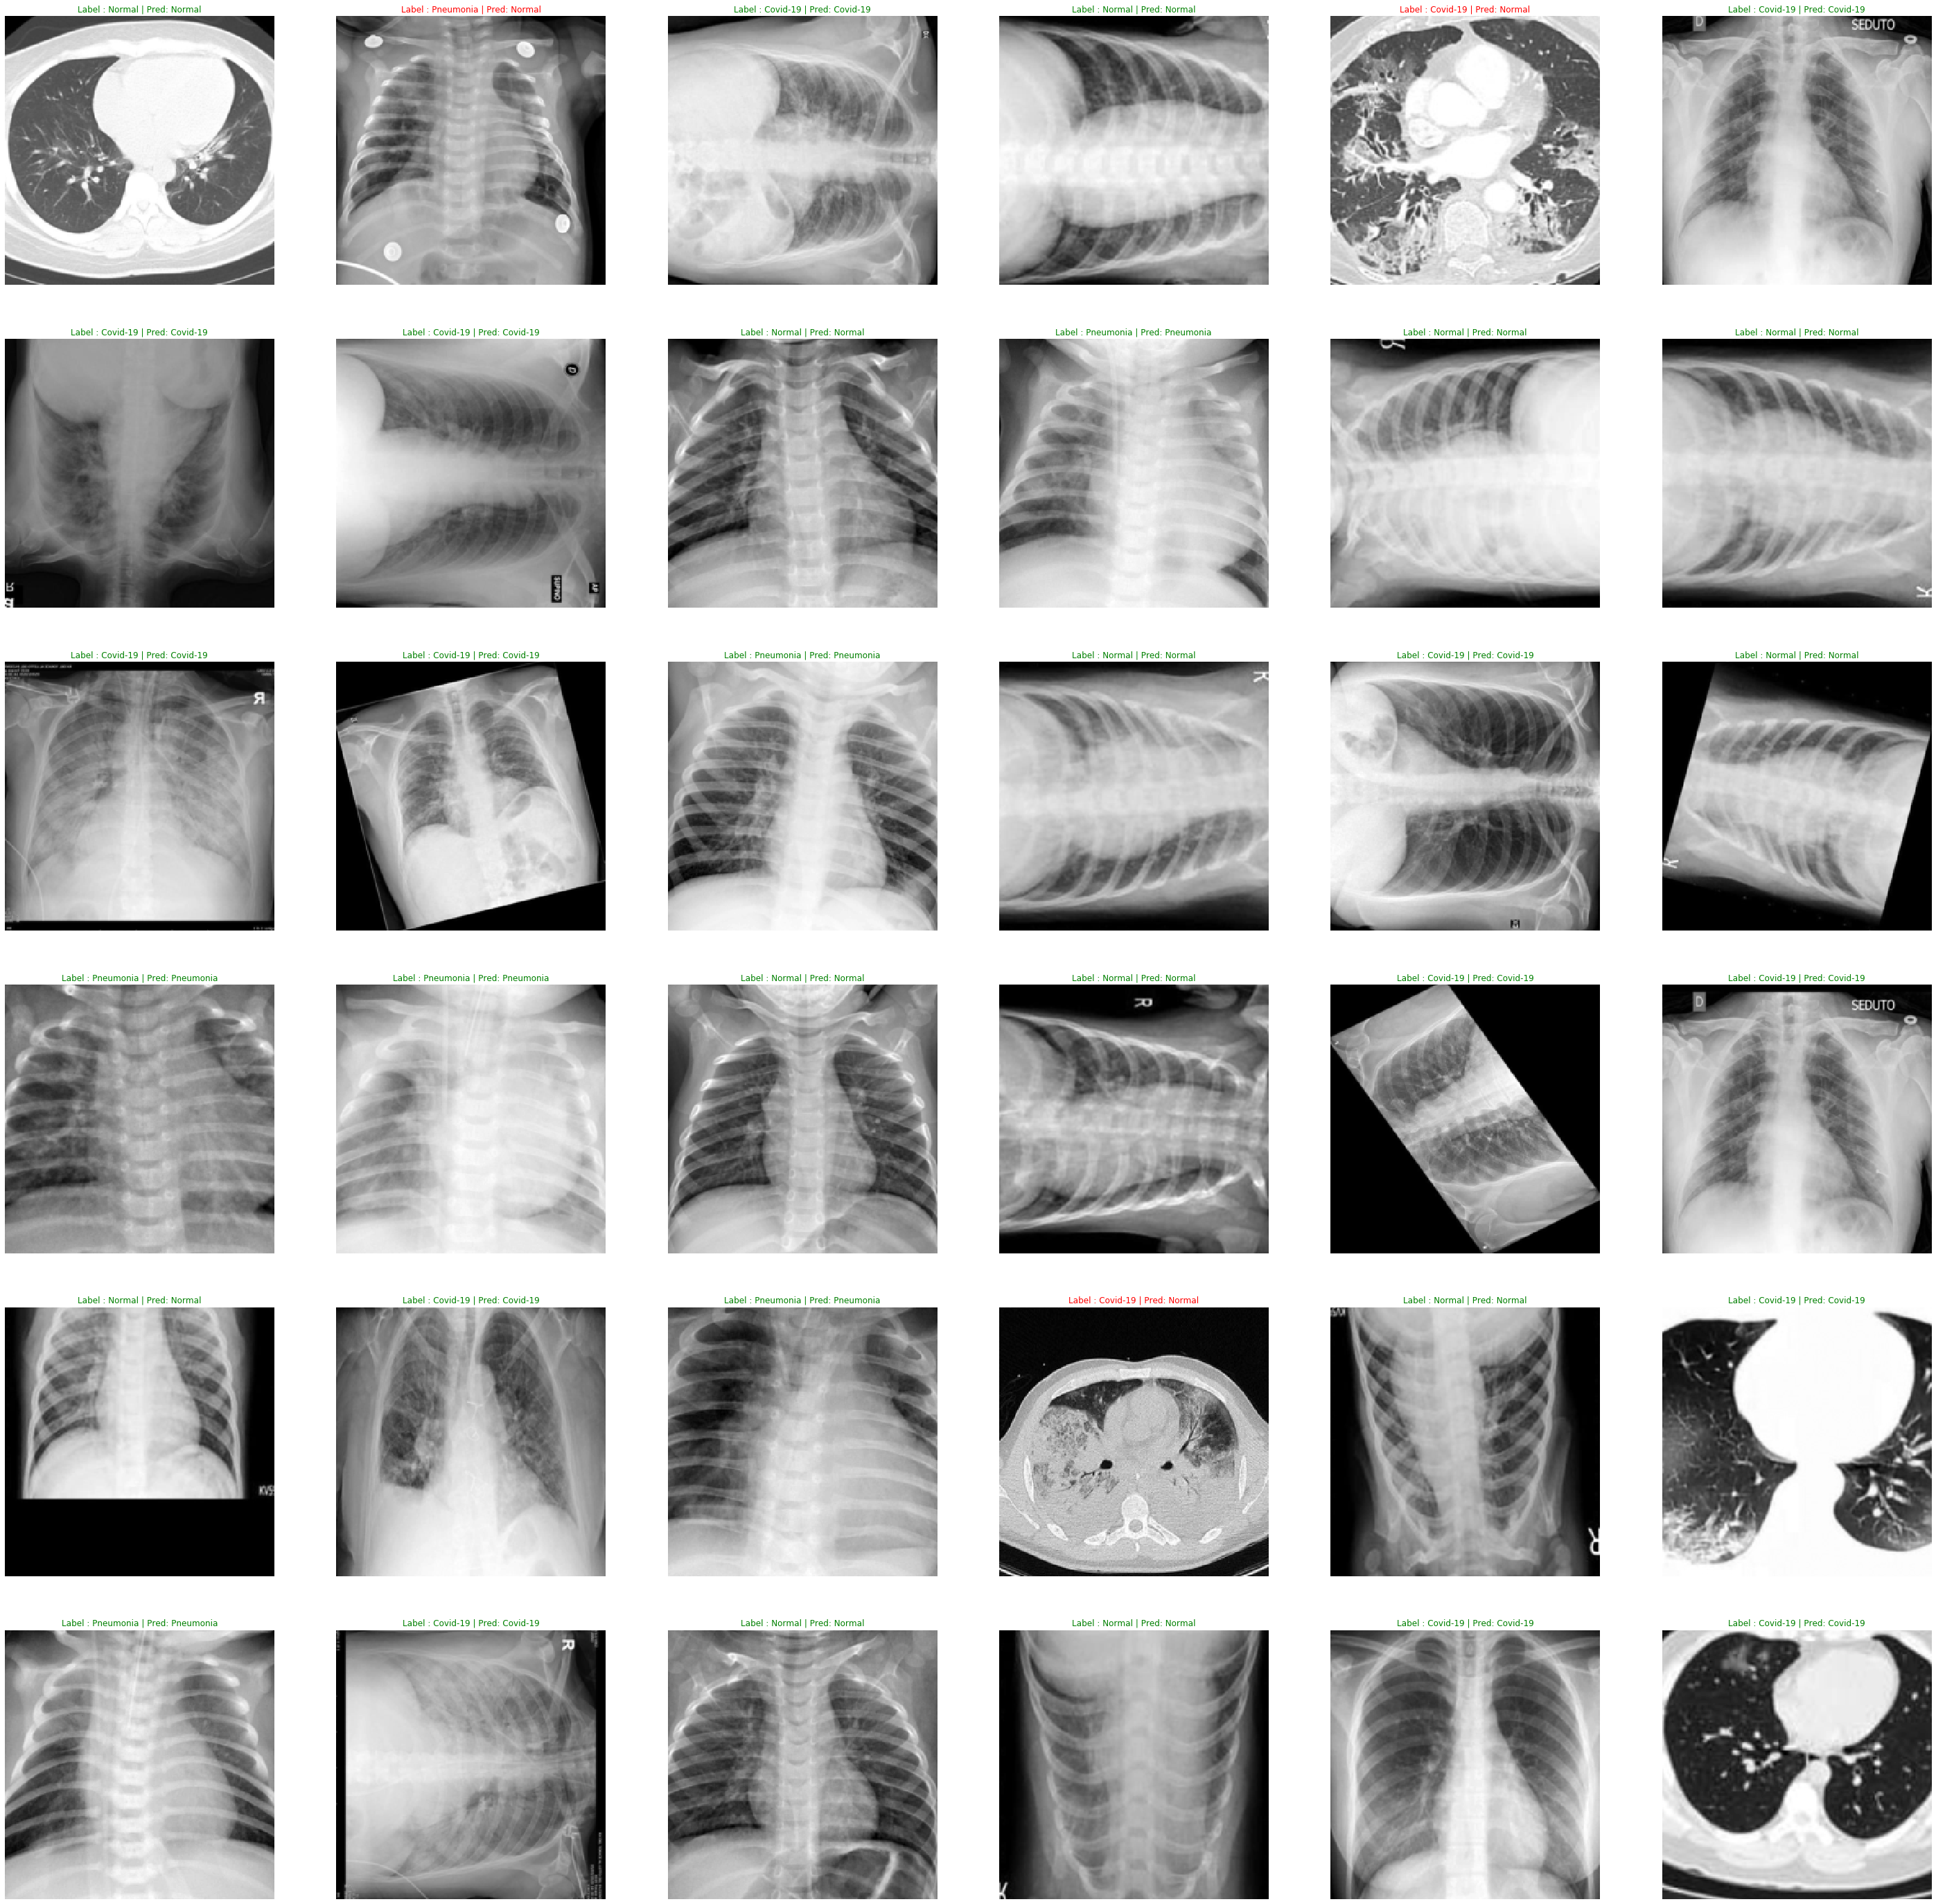

In [33]:
fig, axes = plt.subplots(6,6, figsize=(50, 50))
for img, label, pred, ax in zip(images, labels, preds, axes.flatten()):
    font = {"color" : "g"} if label == pred else {"color":"r"}
    
    ax.imshow(img.view(224, 224).cpu(), cmap='gray')
    font = {"color" : "g"} if label == pred else {"color":"r"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label : {label} | Pred: {pred}", fontdict=font)
    ax.axis("off");
plt.savefig("model-CNN/model-covid/model-covid-multiclass/prediction.png")